In [2]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch

import cooper
from copy import deepcopy as copy

### Maximum entropy

This example is inspired by [this StackExchange question](https://datascience.stackexchange.com/questions/107366/how-do-you-solve-strictly-constrained-optimization-problems-with-pytorch).

>I am trying to solve the following problem using pytorch: given a six sided die whose
>average roll is known to be 4.5, what is the maximum entropy distribution for the faces?

In [202]:
class MaxEntropyDice(torch.nn.Module):
    def __init__(self, num_faces=6, mean_constraint=3.5):
        super().__init__()
        self.mean_constraint = mean_constraint
        p_init = torch.nn.functional.normalize(torch.rand(num_faces), p=1, dim=0)
        self.p = torch.nn.Parameter(p_init)

    def forward(self):
        # self.p.data = torch.clip(self.p.data, min=0., max=1.)
        return self.p


class MaximumEntropy(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        super().__init__(is_constrained=True)

    def closure(self, model):

        prob = model.forward()

        assert torch.all(prob >= 0)

        # Extra multiplication by -1 to *maximize*
        entropy = (-1) * -torch.sum(prob * torch.log(prob))

        # Entries of p>=0 (equiv. -p <= 0)
        ineq_defect = -prob

        prob_sum = torch.sum(prob)
        prob_mean = torch.sum(torch.tensor(range(1, len(prob) + 1)) * prob)
        eq_defect = torch.stack([prob_sum - 1, prob_mean - model.mean_constraint])

        return cooper.CMPState(
            loss=entropy, eq_defect=eq_defect, ineq_defect=ineq_defect
        )

In [223]:
cmp = MaximumEntropy()
formulation = cooper.LagrangianFormulation(cmp)

model = MaxEntropyDice(num_faces=6, mean_constraint=4.5)

primal_optimizer = cooper.optim.ExtraAdam(model.parameters(), lr=5e-3)
dual_optimizer = cooper.optim.partial(cooper.optim.ExtraAdam, lr=1e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [224]:
state_history = OrderedDict()

for iter_num in range(5000):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, model)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, model)

    if iter_num % 5 == 0:
        state_history[iter_num] = {
            "cmp": cmp.state,
            "dual": copy(formulation.state()),
            "params": copy(model.p),
        }

print(cmp.state)

CMPState(loss=tensor(-1.6136, grad_fn=<MulBackward0>), ineq_defect=tensor([-0.0544, -0.0790, -0.1138, -0.1656, -0.2398, -0.3475],
       grad_fn=<NegBackward0>), eq_defect=tensor([-6.0797e-06, -1.2159e-04], grad_fn=<StackBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


In [225]:
# True solution for mean=4.5
a = torch.tensor([0.05435, 0.07877, 0.1142, 0.1654, 0.2398, 0.3475])
-torch.sum(a * torch.log(a))

tensor(1.6136)

In [228]:
# Multiply again by -1 to get objective with original sign
iters, loss_history = zip(
    *[(iter_num, -1 * _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
)
mult_hist = np.stack(
    [_["dual"][1].data.numpy() for (foo, _) in state_history.items()], axis=1
)
eq_defect_hist = np.stack(
    [_["cmp"].eq_defect.data.numpy() for (foo, _) in state_history.items()], axis=1
)

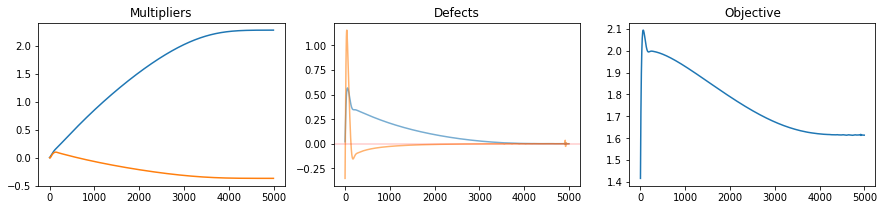

In [229]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(iters, mult_hist.T)
ax0.set_title("Multipliers")

ax1.plot(iters, eq_defect_hist.T, alpha=0.6)
ax1.axhline(0.0, c="r", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(iters, loss_history)
ax2.set_title("Objective")

plt.show()